In [204]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [205]:
import pymysql
from dotenv import load_dotenv
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
plt.rc('font', family = 'Hancom Gothic')

## LightGBM 하이퍼 파라미터 
n_estimators: 100~1000 (early_stopping_rounds 함께 사용 권장)

learning_rate: 0.01~0.2 (낮출수록 n_estimators를 늘려야 함)

max_depth: 5~10 (너무 높이면 과적합)

num_leaves: 15~63 (2^max_depth와 연관, 과적합 방지)

min_child_samples: 10~50 (샘플이 많을수록 높여야)

subsample(또는 bagging_fraction): 0.7~0.9

colsample_bytree(또는 feature_fraction): 0.7~0.9

class_weight: 'balanced'

In [206]:
# 하이퍼파라미터
my_max_depth = 10
my_epochs = 1000
my_learning_rate =0.001
my_optimizer = Adam(learning_rate=my_learning_rate)
my_batch_size = 100 # 작게 하면 더 미세하게 학습, 크게 하면 빠르고 덜 세밀
my_n_estimators = 2000 # 부스팅 반복 횟수(트리 개수)

# 데이터 체크

In [207]:
load_dotenv()
host = os.getenv('host')
user = os.getenv('user')
password = os.getenv('password')
database = os.getenv('database')
port = int(os.getenv('port', 3306))

query =f"""
    SELECT *
    FROM basic_data"""

try:
    connection = pymysql.connect(
        host=host,
        user=user,
        password=password,
        database=database,
        port=port,
        charset='utf8mb4',
        cursorclass=pymysql.cursors.DictCursor
    )
    with connection.cursor() as cursor:
        cursor.execute(query)
        data = cursor.fetchall()
        whole_data = pd.DataFrame(data)
except Exception as e:
    print('에러 발생:', e)
finally:
    try:
        connection.close()
    except:
        pass

In [208]:
whole_data[whole_data['year']!=2025].isna().sum() # 학습에 사용할 데이터 : 21 ~ 24년 데이터, 결측치 X

year                0
month               0
day                 0
hour                0
district            0
datetime            0
total_population    0
season              0
commute_time        0
weekend_flag        0
precipitation       0
temperature         0
humidity            0
wind_speed          0
rental_count        0
dtype: int64

In [209]:
# PM데이터 로드
df_pm = pd.read_csv('PM_data/서울시_시간별_PM_배치_2021_2025.csv', parse_dates=['일시'])
df_pm.columns =['일시','행정구','PM대여량']

In [210]:
df_pm.isna().sum() # 결측치 0건

일시       0
행정구      0
PM대여량    0
dtype: int64

In [211]:
# 데이터 concat
whole_data.columns = ['연도','월','일','시','행정구','일시','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량']

In [212]:
whole_data = whole_data[whole_data['연도']!=2025]
whole_data.shape

(872093, 15)

In [213]:
whole_data.info()
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 872093 entries, 0 to 872092
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   연도        872093 non-null  int64         
 1   월         872093 non-null  int64         
 2   일         872093 non-null  int64         
 3   시         872093 non-null  int64         
 4   행정구       872093 non-null  object        
 5   일시        872093 non-null  datetime64[ns]
 6   총생활인구수    872093 non-null  int64         
 7   계절        872093 non-null  object        
 8   출퇴근시간여부   872093 non-null  object        
 9   주말구분      872093 non-null  int64         
 10  강수        872093 non-null  float64       
 11  기온        872093 non-null  float64       
 12  습도        872093 non-null  float64       
 13  풍속        872093 non-null  float64       
 14  공공자전거대여량  872093 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(6), object(3)
memory usage: 106.5+ MB
<class 

In [214]:
df_total = whole_data.merge(df_pm, on=['행정구','일시'])
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량
0,2021,1,1,0,강남구,2021-01-01 00:00:00,618455,겨울,기타,0,0.0,-4.2,59.0,1.4,9.0,24
1,2021,1,1,0,강동구,2021-01-01 00:00:00,525221,겨울,기타,0,0.0,-6.6,60.0,1.4,12.0,21
2,2021,1,1,0,강북구,2021-01-01 00:00:00,321499,겨울,기타,0,0.0,-5.4,54.0,1.1,12.0,3
3,2021,1,1,0,강서구,2021-01-01 00:00:00,547288,겨울,기타,0,0.0,-3.3,52.0,0.9,27.0,3
4,2021,1,1,0,관악구,2021-01-01 00:00:00,492742,겨울,기타,0,0.0,-2.5,50.0,0.9,19.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662781,2024,12,31,23,송파구,2024-12-31 23:00:00,718964,겨울,기타,0,0.0,0.5,61.0,1.3,115.0,37
662782,2024,12,31,23,양천구,2024-12-31 23:00:00,378141,겨울,기타,0,0.0,1.7,63.0,1.8,101.0,16
662783,2024,12,31,23,영등포구,2024-12-31 23:00:00,420498,겨울,기타,0,0.0,1.3,62.0,1.2,113.0,6
662784,2024,12,31,23,은평구,2024-12-31 23:00:00,453206,겨울,기타,0,0.0,0.3,62.0,1.3,35.0,5


In [215]:
df_total[df_total.isna().any(axis=1)]

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량


In [216]:
# feature 추출
# 시계열 요소
import holidays
kr_holidays = holidays.KR(years=[2021, 2024])
df_total['공휴일'] = df_total['일시'].dt.date.isin(kr_holidays).astype(int)
# df_total
cols_time = ['연도','월','일','시','계절','출퇴근시간여부','주말구분','공휴일']

# 라벨인코더

In [217]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
le_season = LabelEncoder()
le_commute = LabelEncoder()
le_gu = LabelEncoder()
df_total['계절'] = le_season.fit_transform(df_total['계절'].values)
df_total['출퇴근시간여부'] = le_commute.fit_transform(df_total['출퇴근시간여부'].values)
df_total['행정구'] = le_gu.fit_transform(df_total['행정구'].values)
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량,공휴일
0,2021,1,1,0,0,2021-01-01 00:00:00,618455,1,0,0,0.0,-4.2,59.0,1.4,9.0,24,1
1,2021,1,1,0,1,2021-01-01 00:00:00,525221,1,0,0,0.0,-6.6,60.0,1.4,12.0,21,1
2,2021,1,1,0,2,2021-01-01 00:00:00,321499,1,0,0,0.0,-5.4,54.0,1.1,12.0,3,1
3,2021,1,1,0,3,2021-01-01 00:00:00,547288,1,0,0,0.0,-3.3,52.0,0.9,27.0,3,1
4,2021,1,1,0,4,2021-01-01 00:00:00,492742,1,0,0,0.0,-2.5,50.0,0.9,19.0,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662781,2024,12,31,23,14,2024-12-31 23:00:00,718964,1,0,0,0.0,0.5,61.0,1.3,115.0,37,0
662782,2024,12,31,23,15,2024-12-31 23:00:00,378141,1,0,0,0.0,1.7,63.0,1.8,101.0,16,0
662783,2024,12,31,23,16,2024-12-31 23:00:00,420498,1,0,0,0.0,1.3,62.0,1.2,113.0,6,0
662784,2024,12,31,23,17,2024-12-31 23:00:00,453206,1,0,0,0.0,0.3,62.0,1.3,35.0,5,0


# PM운영 행정구와 전체 행정구 체크
- PM의 경우 서울시에 운영현황을 공유한 회사만 체크

In [218]:
df_total['행정구'].unique()
pm_gu_list = le_gu.classes_.tolist()

In [219]:
gu_list = whole_data['행정구'].unique().tolist()

# 스케일 조정
- 시계열 내용 time_cols = ['연도','월','일','시','계절','출퇴근시간여부','주말구분','공휴일'] 를 제외 나머지 연속형 데이터 스케일 조정

In [220]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols_scale = ['총생활인구수', '강수', '기온','습도','풍속','공공자전거대여량'] # 독립변수만
df_total[cols_scale] = scaler.fit_transform(df_total[cols_scale].values)
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량,공휴일
0,2021,1,1,0,0,2021-01-01 00:00:00,0.431544,1,0,0,0.011628,0.519864,0.594059,0.210526,0.002456,24,1
1,2021,1,1,0,1,2021-01-01 00:00:00,0.342346,1,0,0,0.011628,0.492622,0.603960,0.210526,0.003377,21,1
2,2021,1,1,0,2,2021-01-01 00:00:00,0.147441,1,0,0,0.011628,0.506243,0.544554,0.184211,0.003377,3,1
3,2021,1,1,0,3,2021-01-01 00:00:00,0.363457,1,0,0,0.011628,0.530079,0.524752,0.166667,0.007983,3,1
4,2021,1,1,0,4,2021-01-01 00:00:00,0.311272,1,0,0,0.011628,0.539160,0.504950,0.166667,0.005527,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662781,2024,12,31,23,14,2024-12-31 23:00:00,0.527703,1,0,0,0.011628,0.573212,0.613861,0.201754,0.035002,37,0
662782,2024,12,31,23,15,2024-12-31 23:00:00,0.201632,1,0,0,0.011628,0.586833,0.633663,0.245614,0.030703,16,0
662783,2024,12,31,23,16,2024-12-31 23:00:00,0.242155,1,0,0,0.011628,0.582293,0.623762,0.192982,0.034387,6,0
662784,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,5,0


In [221]:
# 1. 1년 전 '연도', '월', '일', '시' 컬럼 생성
df_total['1년전_연도'] = df_total['연도'] - 1

# 2. merge용 key 생성
merge_cols = ['행정구', '1년전_연도', '월', '일', '시']
df_total['merge_key'] = df_total['행정구'].astype(str) + '_' + (df_total['연도']-1).astype(str) + '_' + df_total['월'].astype(str) + '_' + df_total['일'].astype(str) + '_' + df_total['시'].astype(str)

df_total['now_key'] = df_total['행정구'].astype(str) + '_' + df_total['연도'].astype(str) + '_' + df_total['월'].astype(str) + '_' + df_total['일'].astype(str) + '_' + df_total['시'].astype(str)

df_yearago = df_total[['now_key', '총생활인구수', 'PM대여량']].copy()
df_yearago.columns = ['merge_key', '1년전_총생활인구수', '1년전_PM대여량']

df_total = df_total.merge(df_yearago, on='merge_key', how='left')
df_total = df_total.dropna().drop(['merge_key', 'now_key','1년전_연도'],axis=1)

# 타겟변수 범주화

## 범주 기준 clustering

In [177]:
print('타겟변수 최대값 :',df_total['PM대여량'].max())
print('타겟변수 최소값 :',df_total['PM대여량'].min())
print('타겟변수 평균 :',df_total['PM대여량'].mean())
print('타겟변수 표준편차 :',df_total['PM대여량'].std())
display(df_total['PM대여량'].describe())

타겟변수 최대값 : 167
타겟변수 최소값 : 3
타겟변수 평균 : 28.435073610833772
타겟변수 표준편차 : 24.659611717346884


count    550870.000000
mean         28.435074
std          24.659612
min           3.000000
25%           9.000000
50%          22.000000
75%          39.000000
max         167.000000
Name: PM대여량, dtype: float64

### cluster용 샘플 데이터 1.
- 50개 단위로 끊어서 시계열 유지

In [20]:
sample_data = df_total[::50]
sample_data.shape

(11018, 19)

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for n_clusters in range(2,10) :
    cluster = KMeans(n_clusters=n_clusters,
                  n_init = 10,)
    cluster.fit(sample_data[['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']].values)
    pred = cluster.labels_
    score = silhouette_score(X = sample_data[['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']],
                            labels = pred)
    print(f"클러스트수 : {n_clusters}, 실루엣 계수 : {score}")

클러스트수 : 2, 실루엣 계수 : 0.5034152029287449
클러스트수 : 3, 실루엣 계수 : 0.35829080766409677
클러스트수 : 4, 실루엣 계수 : 0.2928090306335364
클러스트수 : 5, 실루엣 계수 : 0.25021259315453737
클러스트수 : 6, 실루엣 계수 : 0.24037891458352895
클러스트수 : 7, 실루엣 계수 : 0.23465306470953057
클러스트수 : 8, 실루엣 계수 : 0.2252786575537092
클러스트수 : 9, 실루엣 계수 : 0.21832308531956343


### cluster용 샘플 데이터 2.
- 1개월 단위로 샘플링
- 연단위의 경우 데이터의 과다(18만개)로 메모리 이슈 발생

In [23]:
del sample_data

In [24]:
sample_data = df_total[df_total['월']==7]
sample_data.shape

(47221, 19)

In [25]:
for n_clusters in range(2,10) :
    cluster = KMeans(n_clusters=n_clusters,
                  n_init = 10,)
    cluster.fit(sample_data[['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']].values)
    pred = cluster.labels_
    score = silhouette_score(X = sample_data[['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']],
                            labels = pred)
    print(f"클러스트수 : {n_clusters}, 실루엣 계수 : {score}")

클러스트수 : 2, 실루엣 계수 : 0.50380245956795
클러스트수 : 3, 실루엣 계수 : 0.3571750579350531
클러스트수 : 4, 실루엣 계수 : 0.31127190214918143
클러스트수 : 5, 실루엣 계수 : 0.2703939030900694
클러스트수 : 6, 실루엣 계수 : 0.27035878459618323
클러스트수 : 7, 실루엣 계수 : 0.26017600961164794
클러스트수 : 8, 실루엣 계수 : 0.25187154305100445
클러스트수 : 9, 실루엣 계수 : 0.244388411222825


### cluster용 샘플 데이터 3.
- 1년 단위로 샘플링
- feature 축소를 통해 메모리 부족 해소

In [26]:
del sample_data

In [27]:
sample_data = df_total[df_total['월']==7]
sample_data.shape

(47221, 19)

In [28]:
for n_clusters in range(2,10) :
    cluster = KMeans(n_clusters=n_clusters,
                  n_init = 10,)
    input_data = sample_data[['연도','월','일','시','행정구','총생활인구수','강수','기온','습도','풍속','공공자전거대여량','1년전_총생활인구수','1년전_PM대여량']].values
    cluster.fit(input_data)
    pred = cluster.labels_
    score = silhouette_score(X = input_data,
                            labels = pred)
    print(f"클러스트수 : {n_clusters}, 실루엣 계수 : {score}")

클러스트수 : 2, 실루엣 계수 : 0.5020230718545858
클러스트수 : 3, 실루엣 계수 : 0.3587312000312493
클러스트수 : 4, 실루엣 계수 : 0.3121305262017013
클러스트수 : 5, 실루엣 계수 : 0.2713132441876673
클러스트수 : 6, 실루엣 계수 : 0.2714484744987242
클러스트수 : 7, 실루엣 계수 : 0.2613360692833384
클러스트수 : 8, 실루엣 계수 : 0.2532321690074345
클러스트수 : 9, 실루엣 계수 : 0.2457243502992503


# 실루엣 계수 분석
```
count    550870.000000
mean         28.435074
std          24.659612
min           3.000000
25%           9.000000
50%          22.000000
75%          39.000000
max         167.000000
```
- cluster가 2~3 개일 때 실루엣계수가 가장 높으나
- 실질적으로 PM을 재배치하기에 구간을 분배하기 위한 조건으로는 부족함.
- 평균이 28이고 Q3가 39인 것을 고려하여 수동 bin 배분이 필요하다고 사료됨.
- 범주는 4분위 수와 편차를 기준으로 아래와 같이 구분하여 학습
    * 0~9 공급과다 
    * 9~39 공급평균 
    * 39 ~ 65 공급다소부족
    * 65 ~ 90 공급부족
    * 90 + 공급절대 부족 5개 구간으로 분리

공급평균      282760
공급과다      126135
공급다소부족     87145
공급부족       38002
공급절대부족     16828
Name: PM대여량_class, dtype: int64


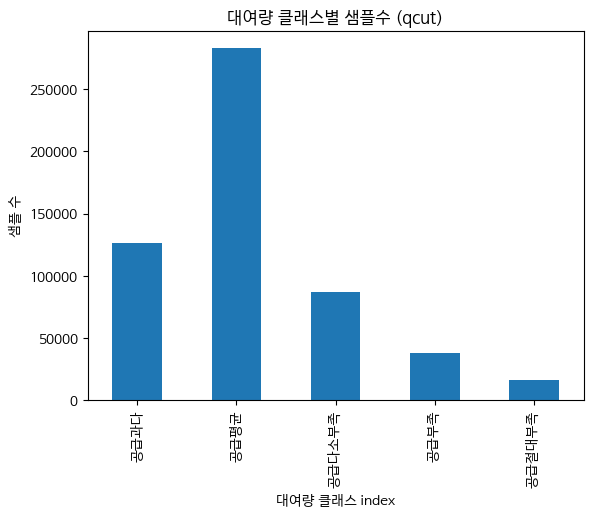

In [222]:
import numpy as np
import pandas as pd
# 타겟변수 범주화
bins = [0, 9, 39, 65, 90, np.inf]
num_bins = len(bins)
labels = ['공급과다', '공급평균', '공급다소부족', '공급부족', '공급절대부족']

# 'PM대여량'을 구간화해서 범주 label로 변환
df_total['PM대여량_class'] = pd.cut(
    df_total['PM대여량'],
    bins=bins,
    labels=labels,
    right=False  # 9, 39, 65, 90은 각 구간의 시작값 포함, 끝값은 미포함
)

# 결과 확인
print(df_total['PM대여량_class'].value_counts())

df_total['PM대여량_class'].value_counts(sort=False).plot(kind='bar')
plt.title('대여량 클래스별 샘플수 (qcut)')
plt.xlabel('대여량 클래스 index')
plt.ylabel('샘플 수')
plt.show()

## 데이터의 불균형이 발생하였으나 절대적인 data의 수가 부족하진 않다고 생각하여 학습 진행

In [223]:
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량,공휴일,1년전_총생활인구수,1년전_PM대여량,PM대여량_class
165265,2022,1,1,0,0,2022-01-01 00:00:00,0.434509,1,0,1,0.011628,0.527809,0.366337,0.210526,0.001228,33,0,0.431544,24.0,공급평균
165266,2022,1,1,0,1,2022-01-01 00:00:00,0.342358,1,0,1,0.011628,0.493757,0.405941,0.192982,0.007062,25,0,0.342346,21.0,공급평균
165267,2022,1,1,0,2,2022-01-01 00:00:00,0.136425,1,0,1,0.011628,0.496027,0.396040,0.157895,0.002763,5,0,0.147441,3.0,공급과다
165268,2022,1,1,0,3,2022-01-01 00:00:00,0.355300,1,0,1,0.011628,0.517594,0.336634,0.219298,0.017808,4,0,0.363457,3.0,공급과다
165269,2022,1,1,0,4,2022-01-01 00:00:00,0.292608,1,0,1,0.011628,0.499432,0.326733,0.245614,0.007676,20,0,0.311272,18.0,공급평균
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718226,2024,12,31,23,16,2024-12-31 23:00:00,0.242155,1,0,0,0.011628,0.582293,0.623762,0.192982,0.034387,6,0,0.229339,7.0,공급과다
718227,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,5,0,0.270446,7.0,공급과다
718228,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,5,0,0.270446,65.0,공급과다
718229,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,52,0,0.270446,7.0,공급다소부족


# 타겟변수 라벨인코딩

In [224]:
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
df_total['PM대여량_class'] = le_target.fit_transform(df_total['PM대여량_class'].values)
df_total['PM대여량_class']

165265    4
165266    4
165267    0
165268    0
165269    4
         ..
718226    0
718227    0
718228    0
718229    1
718230    1
Name: PM대여량_class, Length: 550870, dtype: int32

# feature 선정 

## 상관계수 체크

In [181]:
import pandas as pd
corrs = df_total.corr(numeric_only=True)
corrs['PM대여량'].sort_values(ascending=False)  # 타겟과의 상관계수

PM대여량          1.000000
1년전_PM대여량      0.579309
1년전_총생활인구수     0.326858
총생활인구수         0.322036
출퇴근시간여부        0.169530
시              0.153159
주말구분           0.145724
공공자전거대여량       0.093070
습도             0.086837
기온             0.083839
행정구            0.067721
월              0.044868
PM대여량_class    0.039231
계절             0.008641
강수             0.003174
일              0.001796
공휴일           -0.001834
연도            -0.002853
풍속            -0.108760
Name: PM대여량, dtype: float64

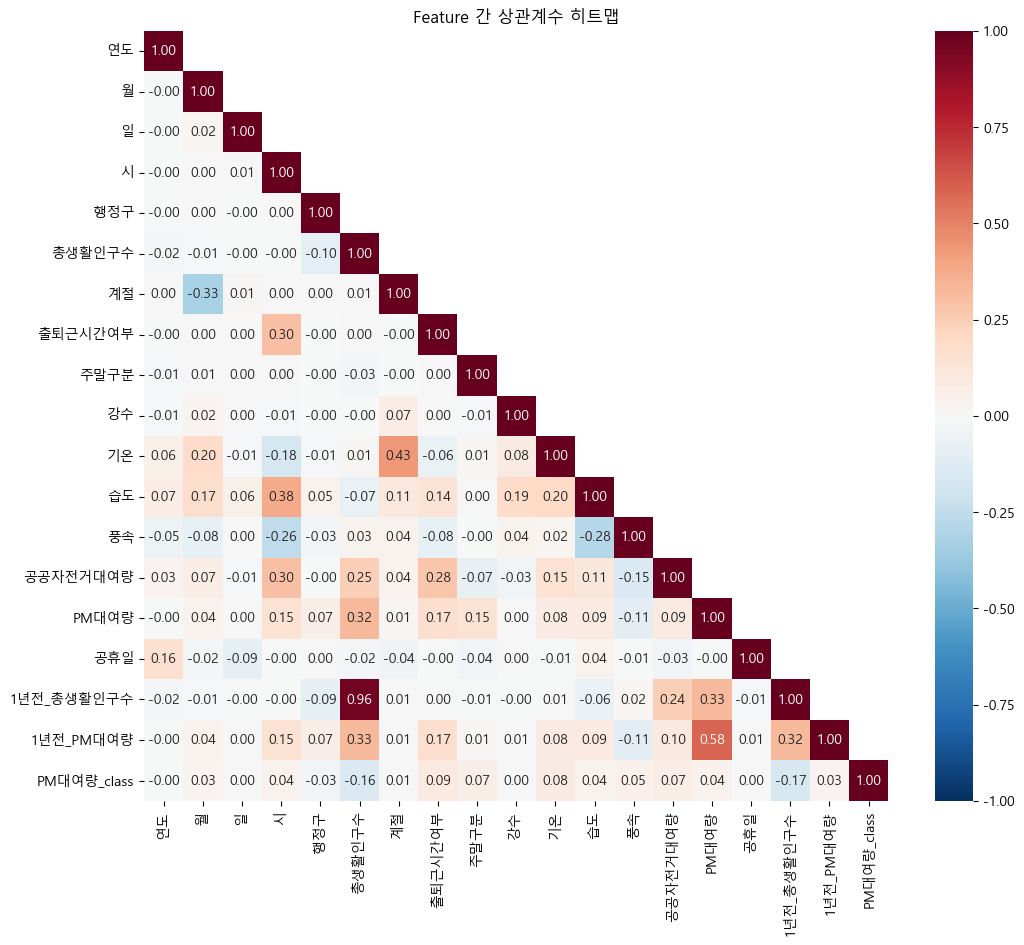

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font',family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

mask = np.triu(np.ones_like(corrs, dtype=bool), k=1)
plt.figure(figsize=(12,10))
sns.heatmap(corrs, annot=True,mask=mask, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Feature 간 상관계수 히트맵')
plt.show()

## 상관계수 분석
- 목표 accuracy 75% + 공급절대부족에서 평균 이하 분류 수를 줄이기 목표(DNN에서 10%)

In [184]:
corrs['PM대여량'].sort_values(ascending=False).index # 결과에 따라 상관계수가 0에 가까운 순으로 제외 예정
sorted_idx = np.abs(corrs)['PM대여량'].sort_values(ascending=False).index
sorted_idx

Index(['PM대여량', '1년전_PM대여량', '1년전_총생활인구수', '총생활인구수', '출퇴근시간여부', '시', '주말구분',
       '풍속', '공공자전거대여량', '습도', '기온', '행정구', '월', 'PM대여량_class', '계절', '강수',
       '연도', '공휴일', '일'],
      dtype='object')

## 데이터 독립변수, 종속변수 분리

In [225]:
# 독립변수, 종속변수 분리용
# 1차 시도 ['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']
# 2차 시도 ['연도','월','일','시','행정구','총생활인구수','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']
# train_set, val_set, test_set
cols_X = ['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']
cols_y = ['PM대여량_class']

train_set = df_total[df_total['연도']<2024]
val_set = df_total[df_total['연도']==2023]
test_set = df_total[df_total['연도']==2024]

train_X = train_set[cols_X]
val_X = val_set[cols_X]
test_X = test_set[cols_X]

train_y = train_set[cols_y].values
val_y = val_set[cols_y].values
test_y = test_set[cols_y].values

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((366582, 17),
 (366582, 1),
 (183602, 17),
 (183602, 1),
 (184288, 17),
 (184288, 1))

# 모델 설계

In [226]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score

In [227]:
lgbm = lgb.LGBMClassifier(
    n_estimators=my_n_estimators,
    learning_rate=my_learning_rate,
    max_depth=my_max_depth,
    class_weight='balanced'  # 클래스 불균형시 유리
)
lgbm

LGBMClassifier(class_weight='balanced', learning_rate=0.001, max_depth=10,
               n_estimators=2000)

# 모델 학습

In [228]:
from lightgbm.callback import log_evaluation, record_evaluation

evals_result = {}

lgbm.fit(
    train_X, train_y.ravel(),
    eval_set=[(train_X, train_y.ravel()), (val_X, val_y.ravel())],
    eval_metric='multi_logloss',
    callbacks=[log_evaluation(20), record_evaluation(evals_result)],
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1593
[LightGBM] [Info] Number of data points in the train set: 366582, number of used features: 16
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[20]	valid_0's multi_logloss: 1.55587	valid_1's multi_logloss: 1.55596
[40]	valid_0's multi_logloss: 1.50621	valid_1's multi_logloss: 1.50637
[60]	valid_0's multi_logloss: 1.46003	valid_1's multi_logloss: 1.46025
[80]	valid_0's multi_logloss: 1.41688	valid_1's multi_logloss: 1.41715
[100]	valid_0's multi_logloss: 1.37634	valid_1's multi_logloss: 1.37666
[120]	valid_0's mult

LGBMClassifier(class_weight='balanced', learning_rate=0.001, max_depth=10,
               n_estimators=2000)

# feature importance 시각화

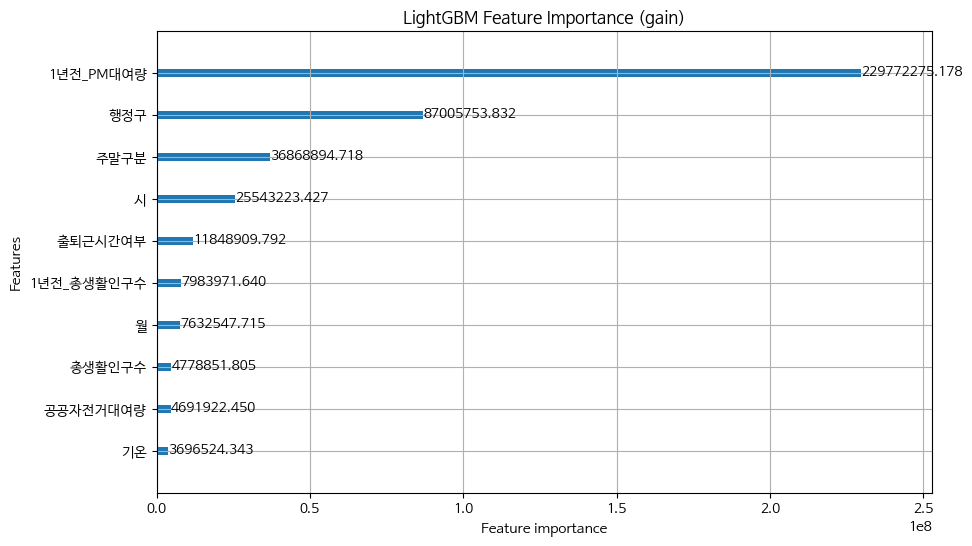

In [229]:
import matplotlib.pyplot as plt

lgb.plot_importance(lgbm, max_num_features=10, importance_type='gain', figsize=(10,6))
plt.title('LightGBM Feature Importance (gain)')
plt.show()

# 학습과정 시각화

In [230]:
train_loss = evals_result['valid_0']['multi_logloss']
val_loss = evals_result['valid_1']['multi_logloss']

In [231]:
train_loss, val_loss, 
np.array(train_loss) - np.array(val_loss)

array([-4.36646203e-06, -8.72190510e-06, -1.31169998e-05, ...,
       -1.77717595e-03, -1.77708896e-03, -1.77733163e-03])

In [233]:
len(train_loss)

2000

In [234]:
import matplotlib.pyplot as plt
plt.rc('font', family = "Malgun Gothic")
train_acc = []
val_acc = []

for i in range(1, len(train_loss) + 1):  # train_loss는 boosting round 개수와 같음
    # 각 iteration별 예측
    if i%10 == 0 :
        print(f"{i}번째 진행")
    y_pred_train = lgbm.predict(train_X, num_iteration=i)
    y_pred_val = lgbm.predict(val_X, num_iteration=i)
    train_acc.append(accuracy_score(train_y, y_pred_train))
    val_acc.append(accuracy_score(val_y, y_pred_val))

10번째 진행
20번째 진행
30번째 진행
40번째 진행
50번째 진행
60번째 진행
70번째 진행
80번째 진행
90번째 진행
100번째 진행
110번째 진행
120번째 진행
130번째 진행
140번째 진행
150번째 진행
160번째 진행
170번째 진행
180번째 진행
190번째 진행
200번째 진행
210번째 진행
220번째 진행
230번째 진행
240번째 진행
250번째 진행
260번째 진행
270번째 진행
280번째 진행
290번째 진행
300번째 진행
310번째 진행
320번째 진행
330번째 진행
340번째 진행
350번째 진행
360번째 진행
370번째 진행
380번째 진행
390번째 진행
400번째 진행
410번째 진행
420번째 진행
430번째 진행
440번째 진행
450번째 진행
460번째 진행
470번째 진행
480번째 진행
490번째 진행
500번째 진행
510번째 진행
520번째 진행
530번째 진행
540번째 진행
550번째 진행
560번째 진행
570번째 진행
580번째 진행
590번째 진행
600번째 진행
610번째 진행
620번째 진행
630번째 진행
640번째 진행
650번째 진행
660번째 진행
670번째 진행
680번째 진행
690번째 진행
700번째 진행
710번째 진행
720번째 진행
730번째 진행
740번째 진행
750번째 진행
760번째 진행
770번째 진행
780번째 진행
790번째 진행
800번째 진행
810번째 진행
820번째 진행
830번째 진행
840번째 진행
850번째 진행
860번째 진행
870번째 진행
880번째 진행
890번째 진행
900번째 진행
910번째 진행
920번째 진행
930번째 진행
940번째 진행
950번째 진행
960번째 진행
970번째 진행
980번째 진행
990번째 진행
1000번째 진행
1010번째 진행
1020번째 진행
1030번째 진행
1040번째 진행
1050번째 진행
1060번째 진행
1070번째 진행
1080번째 진행
1090번째 진행
1100번째 진행
1110번째 진

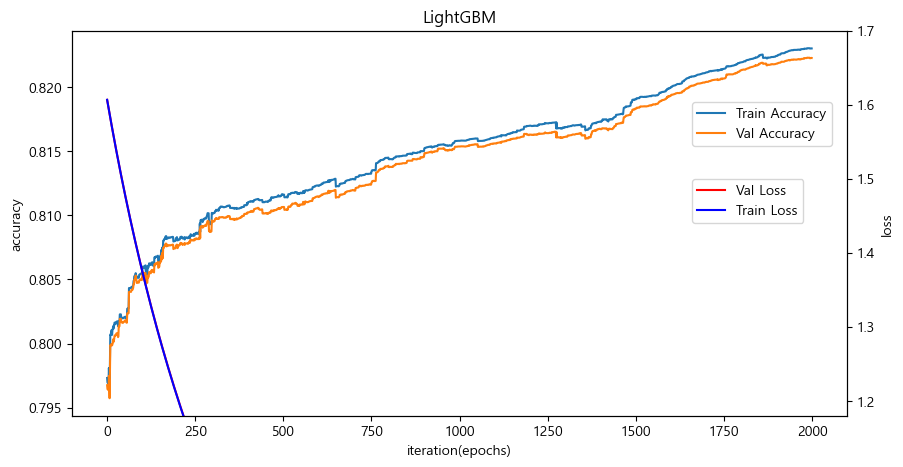

In [235]:
fig, ax1 = plt.subplots(figsize=(10,5))
# accuracy 곡선 그리기
ax1.plot(train_acc, label='Train Accuracy')
ax1.plot(val_acc, label='Val Accuracy')
ax1.set_xlabel('iteration(epochs)')
ax1.set_ylabel('accuracy')
ax1.legend(loc=(0.8,0.7))

ax2 = ax1.twinx()
ax2.plot(val_loss, label='Val Loss',color='red')
ax2.plot(train_loss, label='Train Loss',color='blue')
ax2.set_ylim((1.18,1.7))
ax2.set_ylabel('loss')
ax2.legend(loc=(0.8,0.5))
plt.title('LightGBM')
plt.show()

## val_loss와 train_loss 차이가 1e-3 이하로 몹시 작아 그래프 상 겹친 것과 같이 보임

# 모델의 평가

In [236]:
test_y
y_pred = lgbm.predict(test_X)

In [240]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('accuracy :',round(accuracy_score(test_y, y_pred),2), '%')
print('precision :',round(precision_score(test_y,y_pred,average='weighted'),2), '%')
print('recall :',round(recall_score(test_y,y_pred,average='weighted'),2), '%')
print('f1_score :',round(f1_score(test_y,y_pred,average='weighted'),2), '%')

accuracy : 0.81 %
precision : 0.87 %
recall : 0.81 %
f1_score : 0.83 %


예측값,0,1,2,3,4
실제값,,,,,
0,31595,4512,5283,62,977
1,280,24701,3034,0,1067
2,17,733,10852,963,8
3,0,0,446,5215,0
4,2244,7672,1664,5261,77702


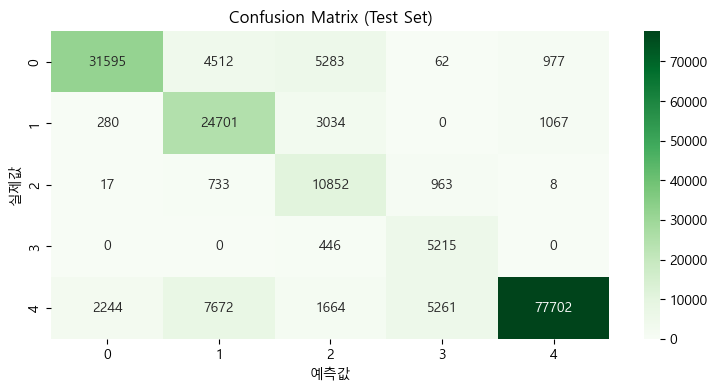

In [241]:
import seaborn as sns
crosstab_y = test_y.reshape(-1)
cm_test = pd.crosstab(crosstab_y, y_pred,rownames=['실제값'],colnames=['예측값'])
display(cm_test)
plt.figure(figsize=(9,4))
sns.heatmap(cm_test.values, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('예측값')
plt.ylabel('실제값')
plt.show()

## 모델평가 : 원하는 accuracy와 recall, precision, f1_score
- 가장 중요한 실제값 4(공급 절대 부족)의 경우 0(공급 과다)로 분류값 또한 양호

In [242]:
real_4_predict_value = cm_test.iloc[4,:]
print("공급절대부족_recall :",round(real_4_predict_value.iloc[4] / real_4_predict_value.sum(), 3)*100, "%")
print("공급절대부족 판별이 필요한데 공급과다로 분류 :",round(real_4_predict_value.iloc[0] / real_4_predict_value.sum(), 3)*100, "%")
print("공급절대부족 판별이 필요한데 평균으로 분류 :",round(real_4_predict_value.iloc[1] / real_4_predict_value.sum(), 3)*100, "%")
print("공급절대부족 판별이 필요한데 공급부족으로 분류 :",round(real_4_predict_value.iloc[2] / real_4_predict_value.sum(), 3)*100, "%")
print("공급절대부족 판별이 필요한데 공급다소부족으로 분류 :",round(real_4_predict_value.iloc[3] / real_4_predict_value.sum(), 3)*100, "%")

공급절대부족_recall : 82.19999999999999 %
공급절대부족 판별이 필요한데 공급과다로 분류 : 2.4 %
공급절대부족 판별이 필요한데 평균으로 분류 : 8.1 %
공급절대부족 판별이 필요한데 공급부족으로 분류 : 1.7999999999999998 %
공급절대부족 판별이 필요한데 공급다소부족으로 분류 : 5.6000000000000005 %


## 공급절대부족 판별을 높이기 위한 방법
    1. feature 수정
    2. 다른 모델 활용

# 모델 저장

In [156]:
# 모델, 스케일러, 인코더, feature 리스트 저장
# pm_gu_list : PM운영 행정구
# gu_list : 서울시 전체 행정구
# le_season : 계절 라벨인코더
# le_commute : 출퇴근시간여부 라벨 인코더
# le_gu : 행정구 인코더
# scaler : 독립변수 스케일러 / cols_scale = ['총생활인구수', '강수', '기온','습도','풍속','공공자전거대여량']
# le_target : 타겟변수 라벨인코더
# feature_cols : 상관계수가 10퍼센트 이상의 feature만 사용
import joblib
joblib.dump(lgbm,'M2_categorical_LGBM.pkl')
joblib.dump(pm_gu_list,'M2_ENCODER\PM활용행정구리스트.pkl')
joblib.dump(gu_list, 'M2_ENCODER\서울전역행정구리스트.pkl')
joblib.dump(le_season, 'M2_ENCODER\계절라벨인코더.pkl')
joblib.dump(le_commute, 'M2_ENCODER\출퇴근시간여부라벨인코더.pkl')
joblib.dump(le_gu, 'M2_ENCODER\행정구라벨인코더.pkl')
joblib.dump(cols_scale, 'M2_ENCODER\독립변수리스트.pkl')
joblib.dump(cols_X, 'M2_ENCODER\실제사용한독립변수리스트.pkl')
joblib.dump(scaler, 'M2_ENCODER\독립변수스케일러.pkl')
joblib.dump(le_target,'M2_ENCODER\타겟변수라벨인코더.pkl')

['M2_ENCODER\\타겟변수라벨인코더.pkl']

# 향후 모델 사용 시 활용 함수

In [157]:
def class_to_range(pred_class):
    ''' 모델 예측 결과를 범주형 결과로 반환하는 함수 '''
    labels = ['공급과다', '공급평균', '공급다소부족', '공급부족', '공급절대부족']
    pred_class = int(pred_class)
    return labels[pred_class]